# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4185.844802,1.0000,-131.886217,2000.91,1869.023783
OMUSDT,526.319895,2180.248346,0.5209,0.000000,1653.93,1653.930000
BTCUSDT,601.021649,917.299884,0.2191,3.537078,316.28,319.817078
SOLUSDT,281.200518,411.443824,0.0983,0.000000,130.24,130.240000
JASMYUSDT,387.458505,313.298165,0.0748,0.000000,-74.16,-74.160000
ETHUSDT,250.747339,215.755307,0.0515,0.000000,-34.99,-34.990000
TRXUSDT,76.868953,116.299048,0.0278,-10.723889,39.43,28.706111
BBUSDT,60.176053,30.360301,0.0073,-39.733101,-29.82,-69.553101
BNBUSDT,1.142121,1.139923,0.0003,-10.606040,-0.00,-10.606040
PEPEUSDT,0.000004,0.000003,0.0000,-38.521986,-0.00,-38.521986


In [20]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [21]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [22]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [23]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [25]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [26]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [27]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [28]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_4696\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [29]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-01-24    -64.480882
2025-01-25    260.437294
2025-01-26    242.122985
2025-01-27    -48.035452
2025-01-28   -142.008285
Name: Total, Length: 128, dtype: float64

In [30]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-01-24    1433.105561
2025-01-25    1693.542854
2025-01-26    1935.665840
2025-01-27    1887.630388
2025-01-28    1745.622103
Name: Total, Length: 128, dtype: float64

In [31]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [32]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [33]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [34]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_4696\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [35]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [36]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [37]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

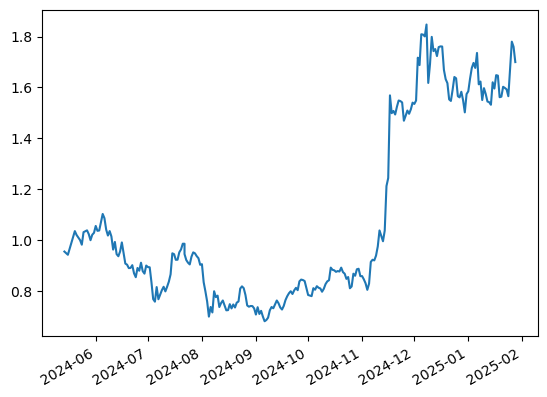

In [38]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [40]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [43]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [44]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [47]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4205
XRPUSDT,0.2116
BNBUSDT,0.2019
SUIUSDT,0.0595
RAYUSDT,0.0509
PEPEUSDT,0.0389
AAVEUSDT,0.0168
ETHUSDT,0.0000
BTCUSDT,0.0000
NEXOUSDT,0.0000


In [48]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.385788
BTCUSDT,0.300000
XRPUSDT,0.155875
BNBUSDT,0.076458
SUIUSDT,0.041855
RAYUSDT,0.037086
PEPEUSDT,0.002938


### Current results

In [50]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [51]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.460756
OMUSDT,0.423253
TRXUSDT,0.115991


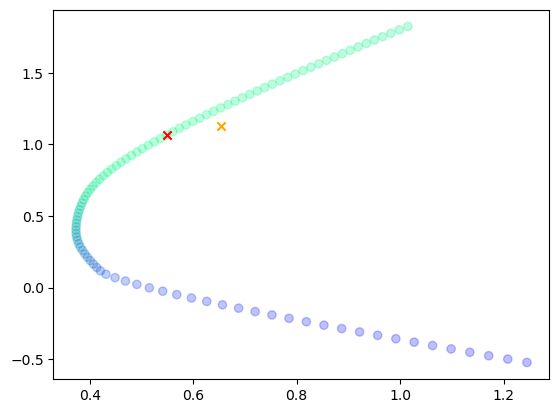

In [52]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [54]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2180.248346,0.520862,0.423253,0.097609
BTCUSDT,917.299884,0.219143,0.460756,-0.241613
SOLUSDT,411.443824,0.098294,0.000000,0.000000
JASMYUSDT,313.298165,0.074847,0.000000,0.000000
ETHUSDT,215.755307,0.051544,0.000000,0.000000
TRXUSDT,116.299048,0.027784,0.115991,-0.088207
BBUSDT,30.360301,0.007253,0.000000,0.000000
BNBUSDT,1.139923,0.000272,0.000000,0.000000
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


In [55]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2180.248346,0.520862,0.385788,0.135074
BTCUSDT,917.299884,0.219143,0.300000,-0.080857
SOLUSDT,411.443824,0.098294,0.000000,0.000000
JASMYUSDT,313.298165,0.074847,0.000000,0.000000
ETHUSDT,215.755307,0.051544,0.000000,0.000000
TRXUSDT,116.299048,0.027784,0.000000,0.000000
BBUSDT,30.360301,0.007253,0.000000,0.000000
BNBUSDT,1.139923,0.000272,0.076458,-0.076186
PEPEUSDT,0.000003,0.000000,0.002938,-0.002938
XRPUSDT,0.000000,0.000000,0.155875,0.000000


# Risk Reward Analysis

In [57]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [58]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

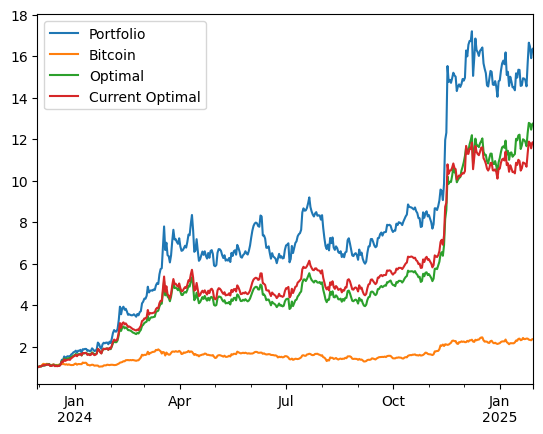

In [59]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [60]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

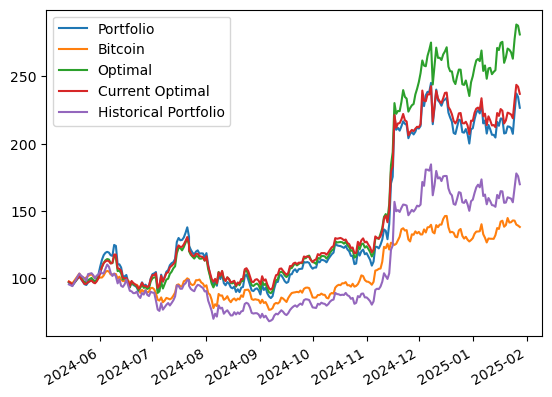

In [61]:
((1+current_perf).cumprod()*100).plot()

In [62]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-01-19,207.643147,138.417370,260.099820,215.098295,156.174667
2025-01-20,208.036422,139.679830,264.115227,217.333912,156.395672
2025-01-21,212.920262,144.886575,270.698309,223.134002,160.268527
2025-01-22,212.652265,141.521058,269.814131,222.552791,159.809659
2025-01-23,211.700537,141.798733,267.859109,221.712499,159.252001
2025-01-24,207.379256,143.102976,263.142016,218.910163,156.577799
2025-01-25,223.252768,142.934147,277.647072,232.176848,167.492235
2025-01-26,237.370977,140.002047,288.531130,243.772736,177.981837
2025-01-27,234.732577,139.267274,287.681566,242.373184,175.966487
2025-01-28,226.727686,138.244001,281.151872,237.083274,169.963707


## Volatilities

In [64]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.618536
 dtype: float64,
 0.6192401816197352)

In [65]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.654007
 dtype: float64,
 0.6540071671082704)

In [66]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.751265
Bitcoin            0.427012
Optimal            0.619240
Current Optimal    0.629910
dtype: float64

In [67]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4487666769074382

In [68]:
days=120
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.5990966590758564

In [69]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7301668165039188

## Risk Contribution

In [71]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.110882,0.076458,0.007515,0.026304,0.003324,0.022980
BTCUSDT,0.406496,0.300000,0.028341,0.127540,0.042796,0.084744
OMUSDT,22.754620,0.385788,0.928283,0.699853,0.588178,0.111675
PEPEUSDT,0.006611,0.002938,0.000383,0.002387,0.000035,0.002352
RAYUSDT,0.178079,0.037086,0.008631,0.035544,0.004807,0.030737
SUIUSDT,0.083020,0.041855,0.005009,0.025282,0.004084,0.021198
XRPUSDT,0.388466,0.155875,0.021836,0.083090,0.028528,0.054561


In [72]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.298746,0.423253,0.666340,0.724721,0.613228,0.111493
BTCUSDT,0.237136,0.460756,0.270054,0.207620,0.114555,0.093065
TRXUSDT,0.048384,0.115991,0.063606,0.067660,0.030599,0.037060


In [73]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.595613,0.52,0.779041,0.759729,0.651192,0.108537
BTCUSDT,0.113227,0.22,0.122706,0.078518,0.018374,0.060144
SOLUSDT,0.024368,0.10,0.045797,0.061987,0.010242,0.051745
JASMYUSDT,-0.018114,0.07,0.019106,0.058984,0.013468,0.045516
ETHUSDT,-0.004570,0.05,0.016729,0.020695,0.001703,0.018992
TRXUSDT,0.012514,0.03,0.015655,0.011039,0.001440,0.009599
BBUSDT,-0.007376,0.01,0.000966,0.009049,0.000362,0.008686


# Value At Risk

## Historical

### Optimal Weights

In [77]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05217552242661095, -0.07362124811643747)

### Current Weights

In [79]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.049165657780589775, -0.07179518843809872)

In [80]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [81]:
var=historical_var.iloc[row]
var

OMUSDT      -0.057597
BTCUSDT      0.001484
SOLUSDT      0.000972
JASMYUSDT    0.002828
ETHUSDT      0.002098
TRXUSDT      0.000433
BBUSDT       0.000524
BNBUSDT      0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049258
Name: 2024-11-18 00:00:00, dtype: float64

In [82]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.048937
BTCUSDT     -0.006921
SOLUSDT     -0.006024
JASMYUSDT   -0.006082
ETHUSDT     -0.002052
TRXUSDT     -0.000886
BBUSDT      -0.000894
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.071795
dtype: float64

## Parametric

### Optimal Weights

In [85]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0641632148388041, -0.08223950127695115)

### Current Weights

In [87]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.0677656321647656, -0.08685680427560562)

## Multivariate

### Optimal Weights

In [90]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05732039829311244, -0.07382023424839584)

### Current Weights

In [92]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06383252131917004, -0.08144645875441416)

In [93]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.049142
BTCUSDT     -0.004408
SOLUSDT     -0.003932
JASMYUSDT   -0.003123
ETHUSDT     -0.001318
TRXUSDT     -0.000855
BBUSDT      -0.000545
Portfolio   -0.063324
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [97]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.058486385781325596, -0.07407784448928974)

### Current Weights

In [99]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06284647735944263, -0.08091314504927896)

In [100]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.047275
BTCUSDT     -0.005198
SOLUSDT     -0.004290
JASMYUSDT   -0.003803
ETHUSDT     -0.001531
TRXUSDT     -0.000519
BBUSDT      -0.000695
Portfolio   -0.063311
dtype: float64

## Student Copula

### Optimal Weights

In [103]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05706229997236197, -0.07292386510956912)

### Current Weights

In [105]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06405080768045646, -0.0839457577272056)

In [106]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.048605
BTCUSDT     -0.005026
SOLUSDT     -0.004055
JASMYUSDT   -0.004078
ETHUSDT     -0.001359
TRXUSDT     -0.000813
BBUSDT      -0.000687
Portfolio   -0.064624
dtype: float64

## Gumbel Copula

### Optimal Weights

In [109]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10506209219262452, -0.15208907023568508)

### Current Weights

In [111]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11997268621561046, -0.17030801014152838)

In [112]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.112361
BTCUSDT     -0.001097
SOLUSDT     -0.001428
JASMYUSDT   -0.004037
ETHUSDT     -0.000721
TRXUSDT      0.000166
BBUSDT       0.000053
Portfolio   -0.119426
dtype: float64

## Monte Carlo

### Optimal

In [115]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [116]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06653473955803343, -0.08293312421155968)

### Current Weights

In [118]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06913008168137544, -0.08674959172911414)

In [119]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.053394
BTCUSDT     -0.005122
SOLUSDT     -0.004393
JASMYUSDT   -0.003514
ETHUSDT     -0.001277
TRXUSDT     -0.000844
BBUSDT      -0.000662
Portfolio   -0.069206
dtype: float64

## VaR Violation

In [121]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054630,-0.097862,-0.083224,-0.017203
2024-01-15,-0.054630,-0.097867,-0.081407,0.017004
2024-01-16,-0.054630,-0.097646,-0.081623,0.044557
2024-01-17,-0.054630,-0.099195,-0.080873,-0.024653
2024-01-18,-0.054630,-0.101507,-0.085699,-0.035551
...,...,...,...,...
2025-01-26,-0.056462,-0.067462,-0.060389,0.039201
2025-01-27,-0.056462,-0.067484,-0.061848,-0.002944
2025-01-28,-0.056462,-0.067522,-0.060282,-0.022698
2025-01-29,-0.056462,-0.066504,-0.059458,0.021862


In [122]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.037379,-0.083856,-0.081369,-0.015666
2024-05-29,-0.037379,-0.081378,-0.073823,-0.008388
2024-05-30,-0.037379,-0.070620,-0.066824,0.027846
2024-05-31,-0.037379,-0.072083,-0.065736,0.038686
2024-06-01,-0.037379,-0.076133,-0.069220,0.055475
...,...,...,...,...
2025-01-26,-0.046075,-0.080653,-0.071592,0.063239
2025-01-27,-0.046075,-0.079692,-0.070971,-0.011115
2025-01-28,-0.047991,-0.083712,-0.075487,-0.034102
2025-01-29,-0.047991,-0.083820,-0.073335,0.026913


<Axes: >

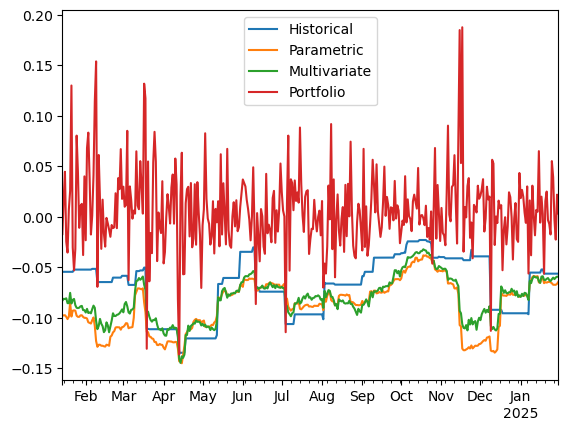

In [123]:
var_data.plot()

<Axes: >

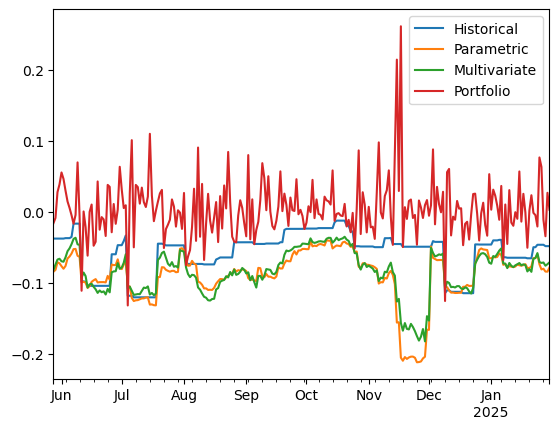

In [124]:
current_var_data.plot()

In [125]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02611,0.010444,0.013055
Kupiec Stat,5.533844,18.394172,15.414643
P-value,0.018652,0.000018,0.000086


In [126]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.060484,0.016129,0.012097
Kupiec Stat,0.539411,8.044777,10.655647
P-value,0.462677,0.004564,0.001097


# Principal Component Analysis

## Historical PCA

In [129]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.7774821 , 0.0714564 , 0.05651264, 0.05236647, 0.04218239])

In [130]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.016200
ADAUSDT      0.016521
ALGOUSDT     0.018805
APTUSDT      0.016923
ARBUSDT      0.018152
ATOMUSDT     0.016537
AVAXUSDT     0.018340
BCHUSDT      0.015377
BNBUSDT      0.008547
BONKUSDT     0.023327
BTCUSDT      0.009604
DOGEUSDT     0.017705
DOTUSDT      0.017447
ENSUSDT      0.020337
EOSUSDT      0.017492
ETCUSDT      0.015952
ETHUSDT      0.012567
FDUSDUSDT    0.000042
FETUSDT      0.022067
FILUSDT      0.019055
FLOKIUSDT    0.023362
FLOWUSDT     0.018667
GALAUSDT     0.022520
GRTUSDT      0.021029
HBARUSDT     0.018305
ICPUSDT      0.017050
IMXUSDT      0.019191
INJUSDT      0.019564
IOTAUSDT     0.019759
JASMYUSDT    0.019657
LDOUSDT      0.019605
LINKUSDT     0.016397
LTCUSDT      0.012701
MKRUSDT      0.013124
NEARUSDT     0.020898
NEOUSDT      0.018645
NEXOUSDT     0.011287
OMUSDT       0.010768
OPUSDT       0.018786
PEPEUSDT     0.023963
QNTUSDT      0.014558
RAYUSDT      0.018537
SANDUSDT     0.020483
SEIUSDT      0.020639
SHIBUSDT     0.018061
SOLUSDT   

<Axes: >

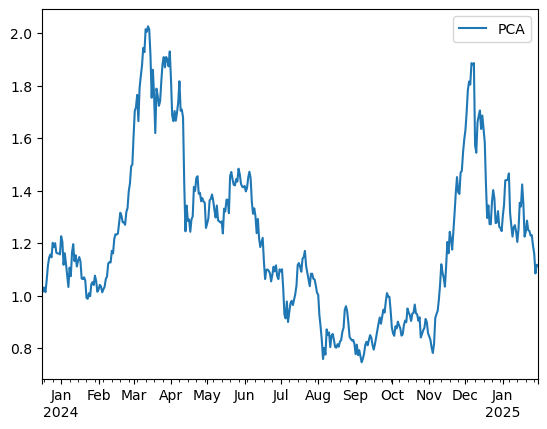

In [131]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

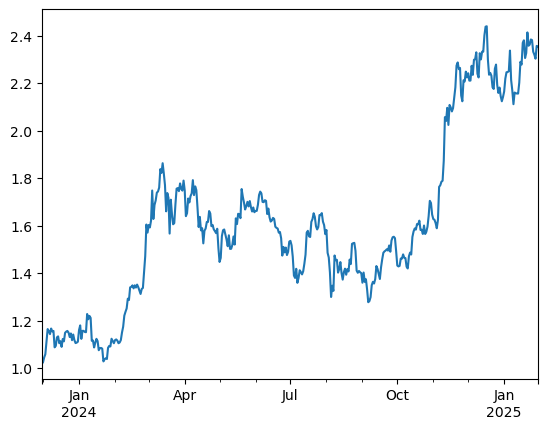

In [132]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [133]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.424471
WBETHUSDT    0.437605
ETHUSDT      0.437830
ATOMUSDT     0.457543
DOTUSDT      0.459844
ETCUSDT      0.462258
NEXOUSDT     0.465413
ADAUSDT      0.501226
WBTCUSDT     0.509902
BTCUSDT      0.510242
EOSUSDT      0.524256
AVAXUSDT     0.530813
IOTAUSDT     0.549890
FILUSDT      0.551790
ARBUSDT      0.566469
GRTUSDT      0.577675
XTZUSDT      0.583262
LINKUSDT     0.596115
IMXUSDT      0.606383
dtype: float64

<Axes: >

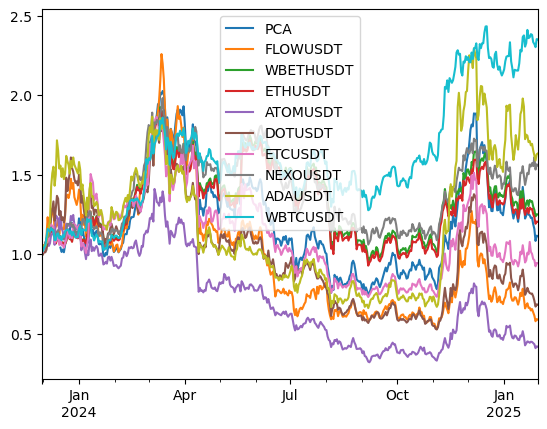

In [134]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

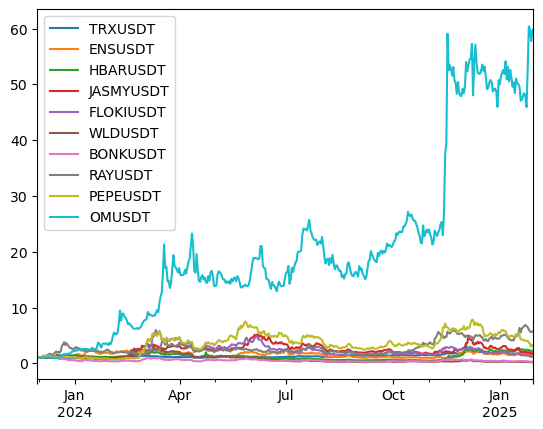

In [135]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [137]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.56016815, 0.14615456, 0.12389448, 0.09873199, 0.07105082])

In [138]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.091626
BTCUSDT      0.060861
SOLUSDT      0.098511
JASMYUSDT    0.173323
ETHUSDT      0.084629
TRXUSDT      0.054339
BBUSDT       0.209581
BNBUSDT      0.065772
PEPEUSDT     0.161357
Name: PC1, dtype: float64

<Axes: >

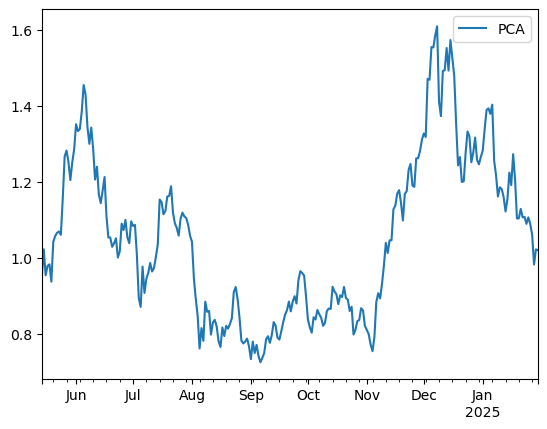

In [139]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

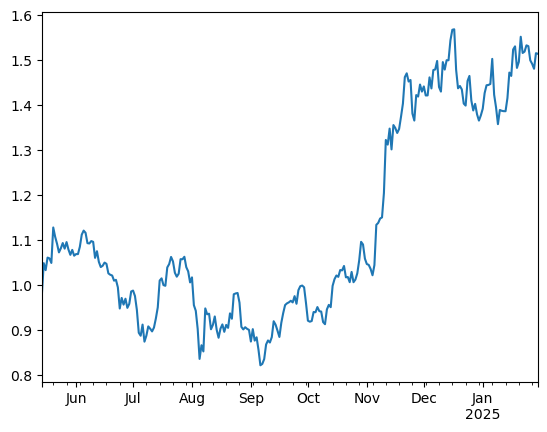

In [140]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [141]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.426688
BNBUSDT      0.454141
BTCUSDT      0.470204
SOLUSDT      0.482985
JASMYUSDT    0.673763
PEPEUSDT     0.735588
BBUSDT       0.762316
TRXUSDT      0.899693
OMUSDT       0.952043
dtype: float64

<Axes: >

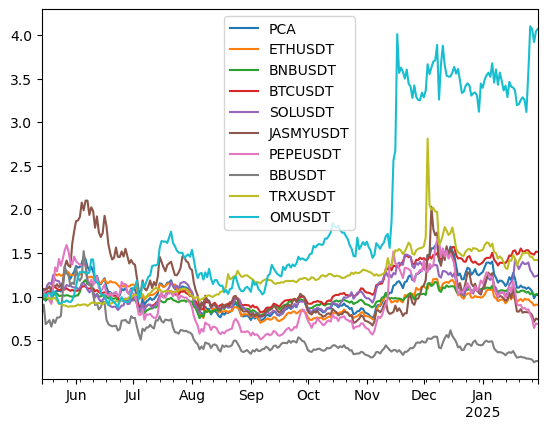

In [142]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [144]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.906826
BBUSDT       1.554254
JASMYUSDT    1.318670
SOLUSDT      1.155643
BTCUSDT      1.000000
ETHUSDT      0.968726
OMUSDT       0.861122
BNBUSDT      0.659652
TRXUSDT      0.317435
Name: BTCUSDT, dtype: float64

In [145]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.192590
PEPEUSDT     2.157331
BBUSDT       1.916862
SOLUSDT      1.325392
ETHUSDT      1.169404
TRXUSDT      1.046269
BTCUSDT      1.000000
BNBUSDT      0.611187
OMUSDT       0.483242
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [147]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [148]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
JASMYUSDT,0.267607
BNBUSDT,0.235590
ETHUSDT,0.192287
BBUSDT,0.170143
BTCUSDT,0.155259
SOLUSDT,0.126227
TRXUSDT,0.047788
PEPEUSDT,0.025265
OMUSDT,-0.023950


### Regression to PCA

In [150]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.779886086399333

In [151]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.285338
BNBUSDT      1.167586
ETHUSDT      1.013108
PCA          1.000000
SOLUSDT      0.738327
JASMYUSDT    0.438490
PEPEUSDT     0.405369
BBUSDT       0.375089
TRXUSDT      0.244895
OMUSDT       0.235538
dtype: float64

In [152]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.805318
BTCUSDT      1.666342
ETHUSDT      1.153093
TRXUSDT      1.119381
PCA          1.000000
BBUSDT       0.721235
PEPEUSDT     0.539757
JASMYUSDT    0.522967
OMUSDT       0.147191
SOLUSDT      0.057692
dtype: float64

### Correlation Matrix

<Axes: >

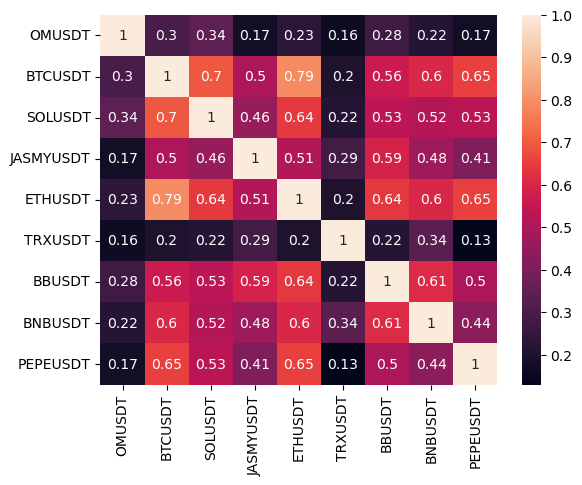

In [154]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

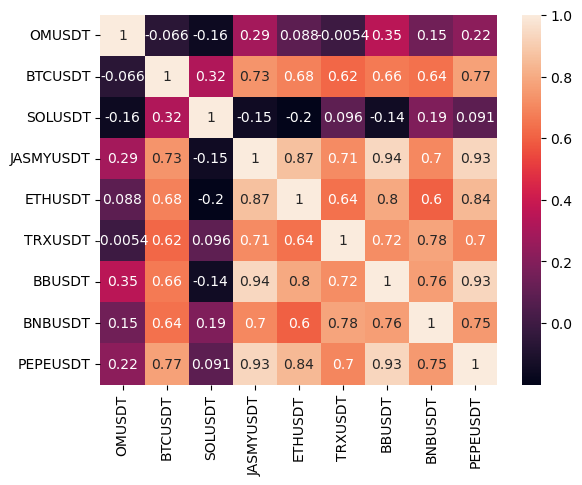

In [155]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [157]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [158]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-06-24,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-07-24,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.633503,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.118266,0.0
2024-08-23,0.923800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076200,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-09-22,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-10-22,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480530,0.0,0.0,0.0,0.0,0.0,0.021218,0.000000,0.000000,0.0
2024-11-21,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.184904,0.216876,0.0
2024-12-21,0.580208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.303750,0.0
2025-01-20,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.448386,0.0
2025-01-30,0.003767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046111,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [159]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

NEXOUSDT    0.469338
OMUSDT      0.357146
BTCUSDT     0.123638
TRXUSDT     0.046111
AAVEUSDT    0.003767
SOLUSDT     0.000000
Name: 2025-01-30 00:00:00, dtype: float64